In [1]:

import pandas as pd
from functools import reduce
import numpy as np
import matplotlib.pyplot as plt

# Read the CSV files into DataFrames
df_fashion = pd.read_csv(r'C:\Users\anais\OneDrive\Área de Trabalho\Nova pasta\fashion.csv')  
df_formal = pd.read_csv(r'C:\Users\anais\OneDrive\Área de Trabalho\Nova pasta\formal wear.csv')
df_casual = pd.read_csv(r'C:\Users\anais\OneDrive\Área de Trabalho\Nova pasta\casual wear.csv')
df_street = pd.read_csv(r'C:\Users\anais\OneDrive\Área de Trabalho\Nova pasta\street wear.csv')
df_merch = pd.read_csv(r'C:\Users\anais\OneDrive\Área de Trabalho\Nova pasta\merchandising.csv')


# Put all DataFrames in a list
dfs = [df_fashion, df_formal, df_casual, df_street, df_merch]

# Clean up each DataFrame
for df in dfs:
    df.reset_index(inplace=True)              # Get country names from index
    df.drop(df.index[0], inplace=True)        # Drop non-data header row
    df.reset_index(drop=True, inplace=True)   # Reset clean index

# Rename columns for consistency
df_fashion.rename(columns={'index': 'Country', 'Categoria: Todas as categorias': 'Fashion'}, inplace=True)
df_formal.rename(columns={'index': 'Country', 'Categoria: Todas as categorias': 'Formal Wear'}, inplace=True)
df_casual.rename(columns={'index': 'Country', 'Categoria: Todas as categorias': 'Casual Wear'}, inplace=True)
df_street.rename(columns={'index': 'Country', 'Categoria: Todas as categorias': 'Street Wear'}, inplace=True)
df_merch.rename(columns={'index': 'Country', 'Categoria: Artes e entretenimento': 'Merchandising'}, inplace=True)


# Sort by country name
for df in dfs:
    df.sort_values(by='Country', inplace=True)

# Merge all DataFrames on 'Country'
merged_df = reduce(lambda left, right: pd.merge(left, right, on='Country', how='inner'), dfs)

# Filter to include only selected countries
countries_to_keep = ['Portugal', 'Sweden', 'Italy', 'United Kingdom', 'Germany', 'France']
filtered_df = merged_df[merged_df['Country'].isin(countries_to_keep)]

# Convert relevant columns to numeric
cols = ['Fashion', 'Casual Wear', 'Formal Wear', 'Street Wear', 'Merchandising']

for col in cols:
    if col in filtered_df.columns:
        filtered_df.loc[:, col] = pd.to_numeric(filtered_df[col], errors='coerce').fillna(0).astype(int)


# Reset index to start from 0
filtered_df.reset_index(drop=True, inplace=True)

# Show the cleaned DataFrame
filtered_df


,Country,Fashion,Formal Wear,Casual Wear,Street Wear,Merchandising
0,France,20,0,9,23,14
1,Germany,23,2,10,11,63
2,Italy,21,10,12,10,19
3,Portugal,22,0,10,30,32
4,Sweden,12,3,9,23,57
5,United Kingdom,24,21,34,74,96


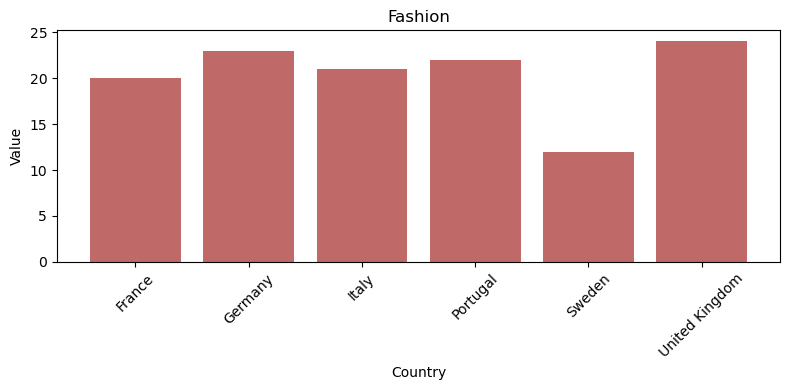

In [8]:
#Which country is merchansing most popular?

column_to_plot = 'Fashion'

plt.figure(figsize=(8, 4))
plt.bar(filtered_df['Country'], filtered_df[column_to_plot], color='brown', alpha=0.7)
plt.title(column_to_plot)
plt.ylabel('Value')
plt.xlabel('Country')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

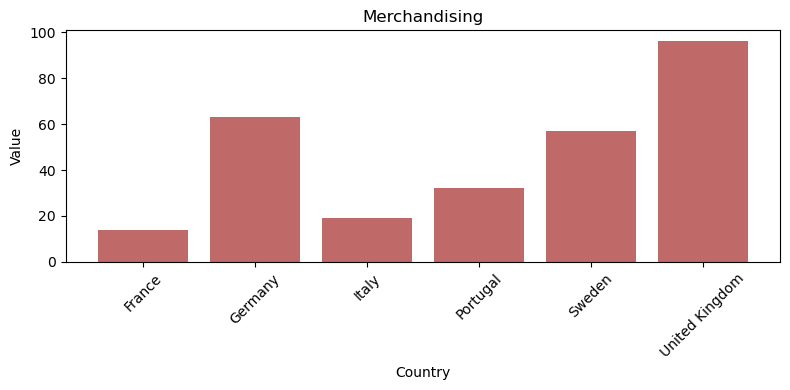

In [9]:
#In which country is merchandising the most popular?

column_to_plot = 'Merchandising'

plt.figure(figsize=(8, 4))
plt.bar(filtered_df['Country'], filtered_df[column_to_plot], color='brown', alpha=0.7)
plt.title(column_to_plot)
plt.ylabel('Value')
plt.xlabel('Country')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


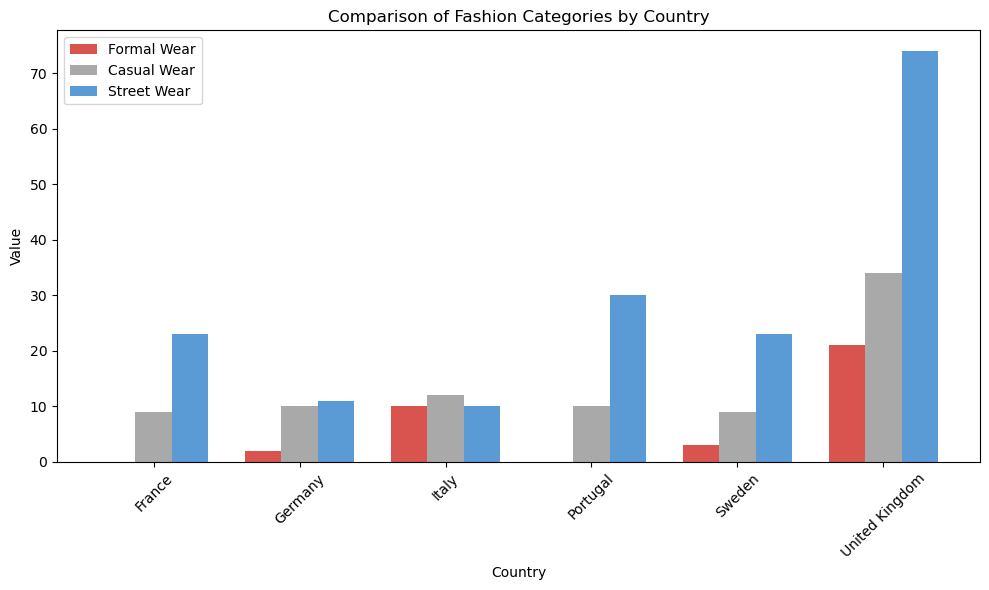

In [10]:
columns_to_plot = ['Formal Wear', 'Casual Wear', 'Street Wear']
colors = ['#D9534F', '#A9A9A9', '#5B9BD5']  # Red, Grey, Blue

countries = filtered_df['Country']
x = np.arange(len(countries))  # Label locations
width = 0.25  # Bar width

fig, ax = plt.subplots(figsize=(10, 6))

for i, column in enumerate(columns_to_plot):
    ax.bar(x + i * width, filtered_df[column], width, label=column, color=colors[i])

ax.set_xlabel('Country')
ax.set_ylabel('Value')
ax.set_title('Comparison of Fashion Categories by Country')
ax.set_xticks(x + width)
ax.set_xticklabels(countries, rotation=45)
ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
import requests
import time
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials 


# Hardcoded country URLs
def get_country_urls():
    return { 
        "France": "https://kworb.net/spotify/country/fr_weekly_totals.html",
        "Germany": "https://kworb.net/spotify/country/de_weekly_totals.html",
        "Italy": "https://kworb.net/spotify/country/it_weekly_totals.html",
        "Portugal": "https://kworb.net/spotify/country/pt_weekly_totals.html",
        "Sweden": "https://kworb.net/spotify/country/se_weekly_totals.html",
        "United Kingdom": "https://kworb.net/spotify/country/gb_weekly_totals.html",
    }

# Parse table from the given URL
def parse_weekly_table(url):
    tables = pd.read_html(url)
    if tables:
        return tables[0]
    return None

# Scrape Top 20 from each country
def scrape_top20_weekly_totals_combined():
    country_urls = get_country_urls()
    all_dfs = []

    for country, url in country_urls.items():
        print(f"Scraping {country} from {url}")
        try:
            df = parse_weekly_table(url)
            if df is not None:
                df = df.head(20)  # Only top 20
                df['Country'] = country
                all_dfs.append(df)
            time.sleep(1)
        except Exception as e:
            print(f"Error scraping {country}: {e}")

    combined_df = pd.concat(all_dfs, ignore_index=True)
    return combined_df

# Run scraping
combined_top20_df = scrape_top20_weekly_totals_combined()
combined_top20_df.to_csv("spotify_top20_weekly_by_country.csv", index=False)
print("✅ Scraping done and saved to 'spotify_top20_weekly_by_country.csv'")

# Load dataset
df_m = pd.read_csv("spotify_top20_weekly_by_country.csv")

# Split "Artist and Title" column safely
split_cols = df_m["Artist and Title"].str.split(" - ", n=1, expand=True)
df_m["Artist"] = split_cols[0]
df_m["Title"] = split_cols[1] if split_cols.shape[1] > 1 else ""

# Spotify API credentials
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(
    client_id=input("your client id: "),
    client_secret=input("your client secret: ")
))

# Function to get genres from Spotify
def get_genres(artist_name):
    try:
        results = sp.search(q=artist_name, type='artist', limit=1)
        return results['artists']['items'][0]['genres']
    except (IndexError, KeyError):
        return []

# Unique artist list
unique_artists = df_m["Artist"].dropna().unique().tolist()
artist_genres_api = {artist: get_genres(artist) for artist in unique_artists}


# Manual genre fallback
manual_genre_map = {
    "Geolier": "rap",
    "Finesse": "trap",
    "Pinguini Tattici Nucleari": "pop rock",
    "Shablo": "rap",
    "Fred De Palma": "reggaeton",
    "Luchè": "urban",
    "AVA": "pop",
    "BLANCO": "pop",
    "Salmo": "hip hop",
    "Capo Plaza": "trap",
    "Ernia": "rap",
    "Tedua": "rap",
    "Coez": "pop rap",
    "Gazzelle": "indie pop",
    "Marracash": "rap",
    "Bizarrap": "latin",
    "Lazza": "hip hop",
    "Annalisa": "pop",
    "Angelina Mango": "pop",
    "Tony Effe": "trap",
    "Baby Gang": "drill",
    "Sfera Ebbasta": "trap",
    "Rose Villain": "alternative pop",
    "Noyz Narcos": "hardcore rap",
    "Guè": "rap",
    "Emis Killa": "rap",
    "Rondodasosa": "drill",
    "Ultimo": "pop",
    "Tananai": "pop",
    "Irama": "pop",
    "Rkomi": "urban pop",
    "Bresh": "urban pop",
    "Rhove": "rap",
    "Ariete": "indie pop",
    "The Weeknd": "pop",
    "Lomepal": "hip hop",
    "Werenoi": "hip hop", 
    "Tom Odell": "alternative rock",
    "Favé": "hip hop",
    "Tones And I": "pop",
    "Glass Animals": "indie pop",
    "The Neighbourhood": "indie rock",
    'Harry Styles': "pop",
    "iñigo quintero": "pop rock",
    "Victor Leksell": "pop",
    "Mares": "pop",
    "Hozier": "rock",
    "Noah Kahan": "indie folk",
    "Post Malone": "pop",
    "Babblarna" : "children's music",
    "Humlan Djojj": "children's music",
    
}

# Assign genre (API first, then manual)
def resolve_genre(artist):
    genres = artist_genres_api.get(artist, [])
    if genres:
        return ", ".join(genres)
    return manual_genre_map.get(artist, "")

df_m["Genre"] = df_m["Artist"].apply(resolve_genre)


 #Drop unnecessary columns
df_m.drop('Artist and Title', axis=1, inplace=True)

# Reorder columns: Artist, Title, Weeks, Top 10 (then others)
df_m.rename(columns={
    "Wks": "Weeks",
    "T10": "Top 10",
    "Pk": "Peak",
    "PkStreams": "Peak Streams",
    "(x?)": "Peak Count"  # Rename (x?) to something descriptive
}, inplace=True)

priority_cols = ["Artist", "Title", "Weeks", "Top 10"]
other_cols = [col for col in df_m.columns if col not in priority_cols]
df_m = df_m[priority_cols + other_cols]

df_m['Peak Count'] = df_m['Peak Count'].str.replace(r'\D', '', regex=True)


import re

# Dictionary of simplified genres: keys = patterns, values = new genres
genre_map = {
    r'\bhip hop\b': 'hip hop',
    r'\brap\b': 'hip hop',
    r'\btrap\b': 'hip hop',
    r'\bpop\b': 'pop',
    r'\brock\b': 'rock',
    r'\bedm\b': 'edm',
    r'\bdance\b': 'edm',
    r'\belectronic\b': 'edm',
    r'\btechno\b': 'edm'
}

# Lowercase all genres to standardize
df_m['Genre'] = df_m['Genre'].str.lower()

# Replace each pattern with the simplified label
for pattern, replacement in genre_map.items():
    df_m['Genre'] = df_m['Genre'].str.replace(pattern, replacement, regex=True)

# Clean up multi-label genres, e.g., "hip hop pop" → just one label
def keep_first_match(genre):
    for g in ['hip hop', 'pop', 'rock', 'edm']:
        if g in genre:
            return g
    return genre  # keep as-is if no match

df_m['Genre'] = df_m['Genre'].apply(keep_first_match)


# Convert relevant columns to numeric
cols = ['Top 10', 'Peak Count']
for col in cols:
    df_m.loc[:, col] = pd.to_numeric(df_m[col], errors='coerce').fillna(0).astype(int)
    
df_m['Top 10'] = df_m['Top 10'].astype('Int64')
df_m['Peak Count'] = df_m['Peak Count'].astype('Int64')

# Save final output
df_m.to_csv("spotify_top20_weekly_by_country_with_full_genres.csv", index=False)
print("✅ Final file saved as 'spotify_top20_weekly_by_country_with_full_genres.csv'")


Scraping France from https://kworb.net/spotify/country/fr_weekly_totals.html
Scraping Germany from https://kworb.net/spotify/country/de_weekly_totals.html
Scraping Italy from https://kworb.net/spotify/country/it_weekly_totals.html
Scraping Portugal from https://kworb.net/spotify/country/pt_weekly_totals.html
Scraping Sweden from https://kworb.net/spotify/country/se_weekly_totals.html
Scraping United Kingdom from https://kworb.net/spotify/country/gb_weekly_totals.html
✅ Scraping done and saved to 'spotify_top20_weekly_by_country.csv'
✅ Final file saved as 'spotify_top20_weekly_by_country_with_full_genres.csv'


C:\Users\anais\AppData\Local\Temp\ipykernel_40256\3399364662.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_total.index[:5], y=genre_total.values[:5], palette=colors)


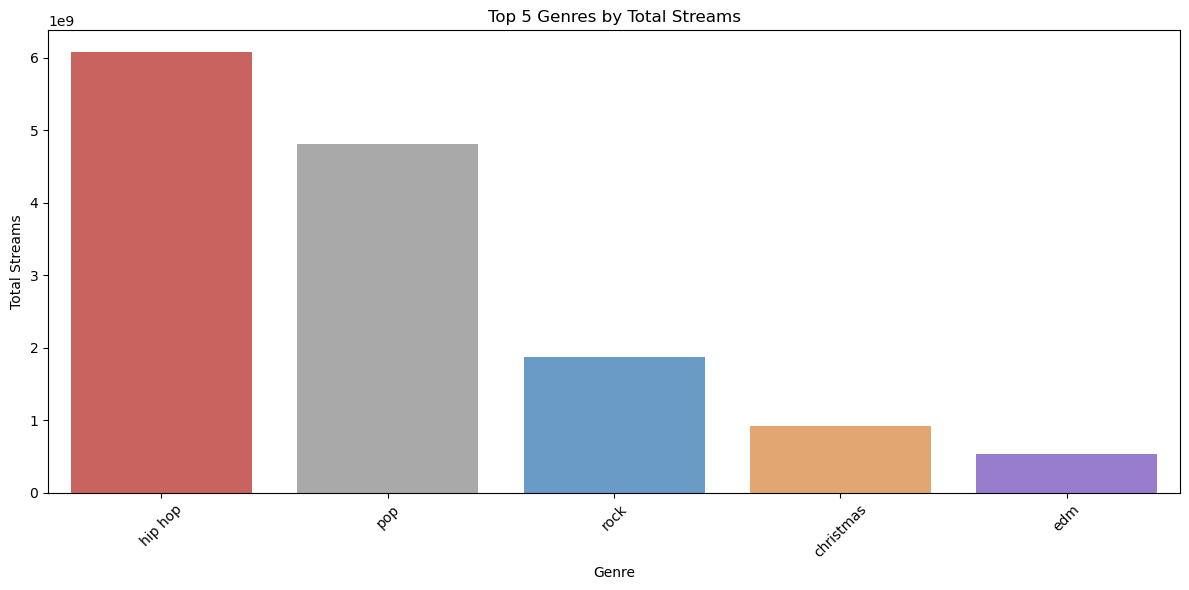

In [12]:
import seaborn as sns

# What is the most listened genre?
genre_total = df_m.groupby('Genre')['Total'].sum().sort_values(ascending=False)

# Custom color list for top 5 genres
colors = ['#D9534F', '#A9A9A9', '#5B9BD5', '#F4A460', '#9370DB']  # Red, Grey, Blue, SandyBrown, MediumPurple

plt.figure(figsize=(12, 6))
sns.barplot(x=genre_total.index[:5], y=genre_total.values[:5], palette=colors)
plt.title("Top 5 Genres by Total Streams")
plt.ylabel("Total Streams")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



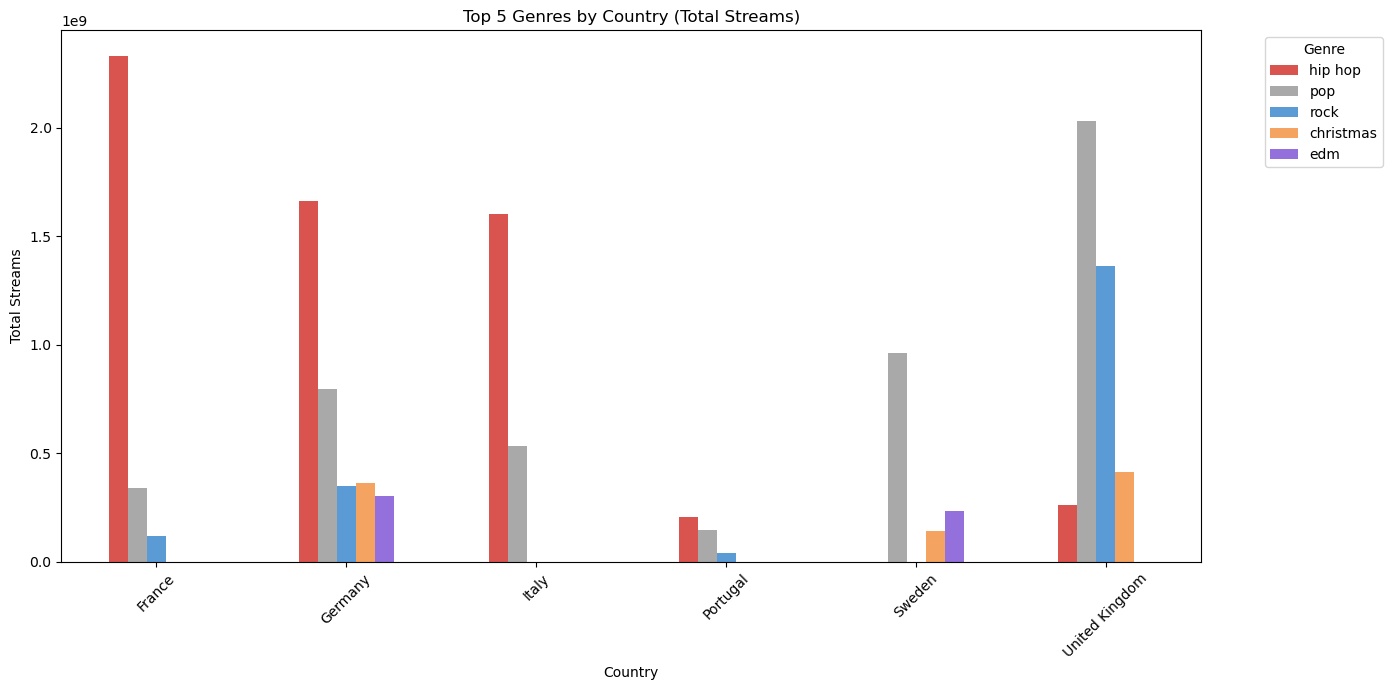

In [5]:

# Group by Country and Genre, summing total streams
grouped = df_m.groupby(['Country', 'Genre'])['Total'].sum().reset_index()

# Find the top 5 genres overall (not per country)
top_genres = df_m.groupby('Genre')['Total'].sum().sort_values(ascending=False).head(5).index.tolist()

# Filter the grouped data to only include the top 5 genres
filtered = grouped[grouped['Genre'].isin(top_genres)]

# Pivot so that countries are the index, genres are columns
genre_streams = filtered.pivot(index='Country', columns='Genre', values='Total').fillna(0)

# Reorder columns to match top_genres order (important for colors)
genre_streams = genre_streams[top_genres]

# Plotting
custom_colors = ['#D9534F', '#A9A9A9', '#5B9BD5', '#F4A460', '#9370DB']

genre_streams.plot(kind='bar', figsize=(14, 7), color=custom_colors)

plt.title('Top 5 Genres by Country (Total Streams)')
plt.xlabel('Country')
plt.ylabel('Total Streams')
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


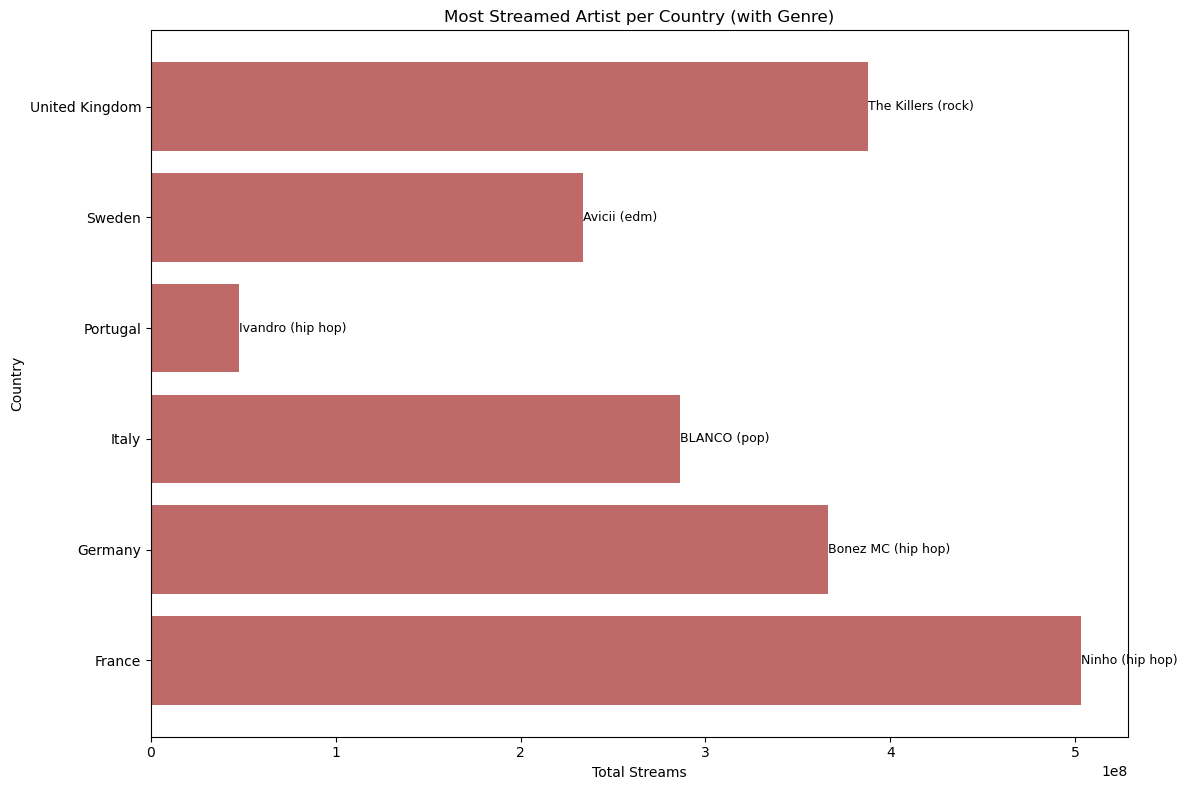

In [ ]:
# Get most streamed artist per country
country_artist = df_m.groupby(['Country', 'Artist', 'Genre'])['Total'].sum().reset_index()
country_artist = country_artist.sort_values(['Country', 'Total'], ascending=[True, False])
top_artist_per_country = country_artist.groupby('Country').first().reset_index()

# Create a label like "Artist (Genre)"
top_artist_per_country['Label'] = top_artist_per_country['Artist'] + " (" + top_artist_per_country['Genre'] + ")"

# Step 3: Plot
plt.figure(figsize=(12, 8))
plt.barh(top_artist_per_country['Country'], top_artist_per_country['Total'], color='brown', alpha=0.7)
plt.title('Most Streamed Artist per Country (with Genre)')
plt.xlabel('Total Streams')
plt.ylabel('Country')

# Add artist + genre labels next to bars
for i, row in top_artist_per_country.iterrows():
    plt.text(row['Total'], i, row['Label'], va='center', ha='left', fontsize=9)

plt.tight_layout()
plt.show()


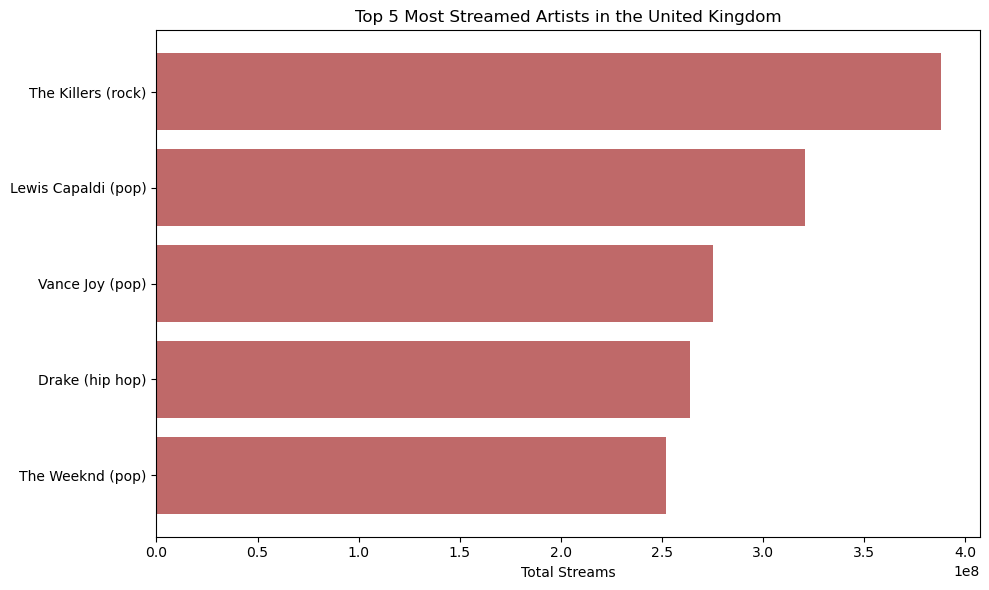

In [ ]:
# Filter for United Kingdom
uk_df = df_m[df_m['Country'] == 'United Kingdom']

# Group by Artist and sum total streams
top5_uk = (
    uk_df.groupby(['Artist', 'Genre'])['Total']
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .reset_index()
)

#  Create label: "Artist (Genre)"
top5_uk['Label'] = top5_uk['Artist'] + " (" + top5_uk['Genre'] + ")"

# Plot
plt.figure(figsize=(10, 6))
plt.barh(top5_uk['Label'], top5_uk['Total'], color='brown', alpha=0.7)
plt.gca().invert_yaxis()
plt.title('Top 5 Most Streamed Artists in the United Kingdom')
plt.xlabel('Total Streams')
plt.tight_layout()
plt.show()